# Google Colab 한글 폰트 설치

In [ ]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

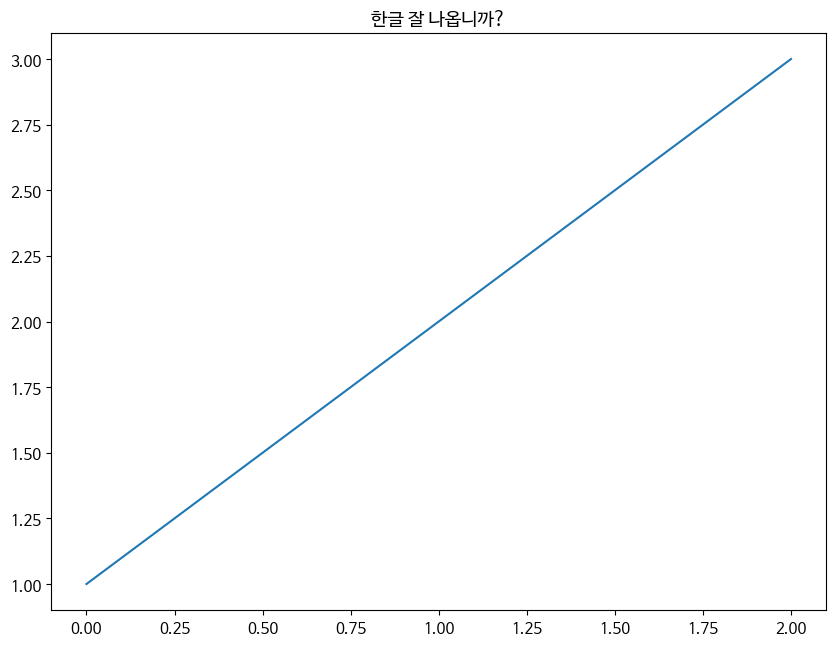

In [ ]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 주요 라이브러리 및 환경설정

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 데이터 불러오기
- UCI 기계학습 Repo에서 사용할 수 있는 원본 데이터 집합의 단축 및 정리된 버전
- 2016년 9월 29일 오후 5시에 시작, 2019년 9울 30일 오후 11시에 끝.

In [ ]:
import pandas as pd
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/"

train_df = pd.read_csv(DATA_PATH + 'train.csv', index_col=0)
val_df = pd.read_csv(DATA_PATH + 'val.csv', index_col=0)
test_df = pd.read_csv(DATA_PATH + 'test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# DataWindow 클래스
- 입력의 너비, 레이블의 너비, 이동(shift)을 기반으로 한다.
- 입력의 너비는 단순히 예측을 위해 모델에 입력되는 시간 단계의 개수
  + 24시간의 데이터 입력, 입력의 너비는 24
  + 12시간의 데이터 입력, 입력의 너비는 12
- 레이블의 너비 : 예측의 시간 단계 수와 동일
  + 하나의 시간 단계만 예측 : 레이블 너비 1
  + 하루 동안의 데이터를 예측하는 경우 레이블 너비 24
- 이동은 입력과 예측을 구분하는 시간 단계의 수
  + 다음 시간 단계를 예측하는 경우 이동의 너비는 1
  + 다음 24시간을 예측하는 경우 이동의 너비는 24

## split_to_inputs_labels 함수
- 데이터 윈도우 입력, 레이블, 두 개의 윈도우로 분리
- 큰 데이터 윈도우를 입력과 레이블, 두 개의 윈도우로 간단히 분리

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

# Autoregressive LSTM 모델

## 데이터 윈도우 정의
- 입력과 레이블 배열에는 각각 24개의 시간 단계가 있음
- 모델이 24개의 예측을 출력하도록 shift를 24로 지정
- 목표는 교통량

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [ ]:
# 기존 값 참조
ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070, 0.078, 0.069]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058, 0.063, 0.055]

## ARLSTM 클래스 정의
- self : AutoRegressive 클래스의 인스턴스 참조
- units : 계층에 있는 뉴런의 개수 나타내기
- out_steps : 예측 배열의 길이 나타내기

In [ ]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

## 모델 구축 및 학습

In [ ]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)
history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0892 - mean_absolute_error: 0.2269 - val_loss: 0.0185 - val_mean_absolute_error: 0.0974
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0167 - mean_absolute_error: 0.0921 - val_loss: 0.0165 - val_mean_absolute_error: 0.0896
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0152 - mean_absolute_error: 0.0859 - val_loss: 0.0159 - val_mean_absolute_error: 0.0867
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0145 - mean_absolute_error: 0.0832 - val_loss: 0.0160 - val_mean_absolute_error: 0.0882
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0142 - mean_absolute_error: 0.0819 - val_loss: 0.0152 - val_mean_absolute_error: 0.0854
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0138 - mean_absolute_error: 0.0802 - val_loss: 0.0146 - val_mean_absolute_error: 0.0824
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0133 - mean_absolute_error: 

## 예측 시각화
- 어느정도 근사적으로 맞는 것 확인

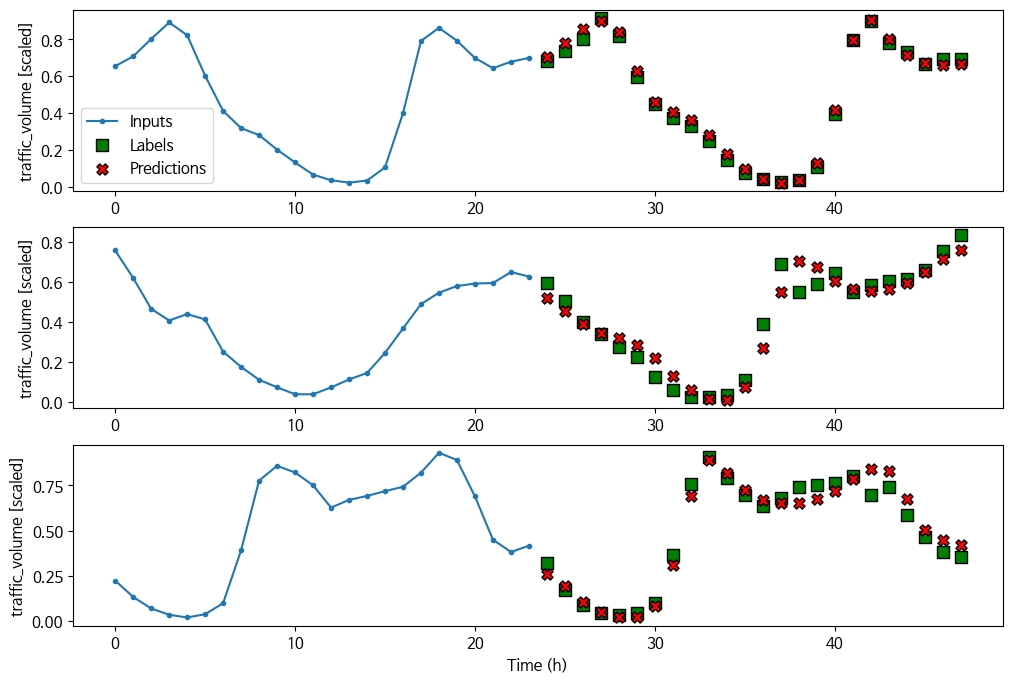

In [ ]:
multi_window.plot(AR_LSTM)

## 기존 모델과 비교

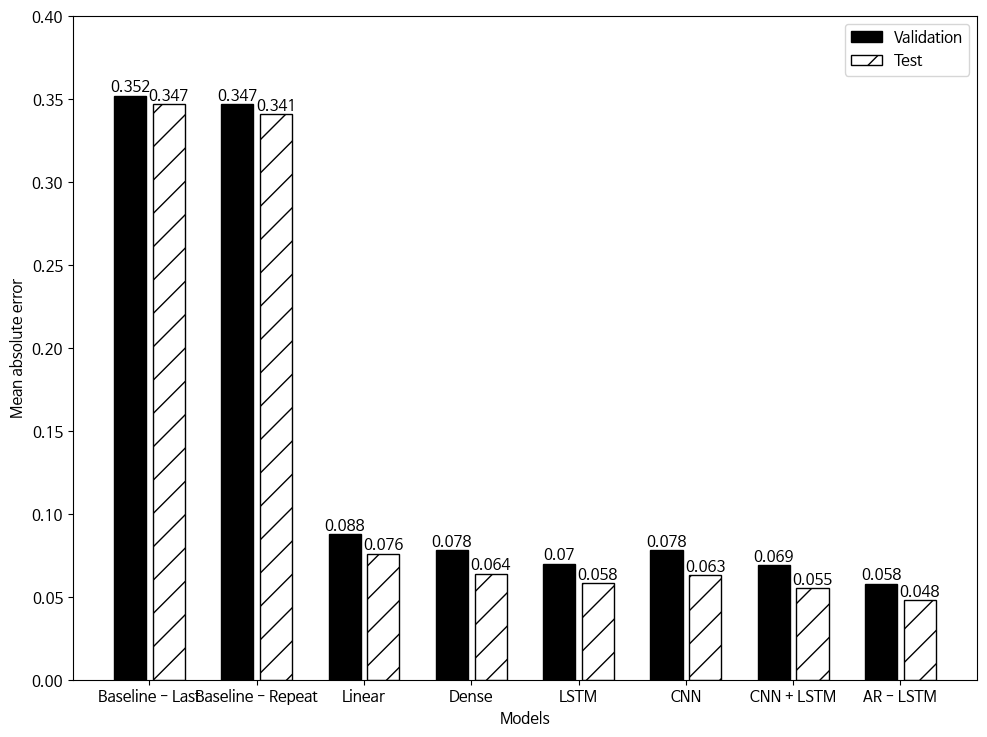

In [ ]:
ms_mae_val.append(ms_val_performance['AR - LSTM'][1])
ms_mae_test.append(ms_performance['AR - LSTM'][1])

x = np.arange(8)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.show()